<a href="https://colab.research.google.com/github/simplifique-treinamentos/curso-intro-python/blob/main/extra_predicao_categorica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Desenvolvendo um modelo preditivo com scikit-learn

#1) Carga e análise de dados

Usaremos o modelo de **regressão logística** para **PREDIÇÃO** de um **desfecho binário (doente/não doente)**. <br /><br />

Este modelo pertence ao grupo **GLM** (*Generalized Linear Models*) e é comumente utilizado para **inferência** em que se deseja descobrir os fatores associados. Tem como suposições básicas que o valor do desfecho (Y) é um evento binário e os preditores são independentes entre si (X) e tem a seguinte fórmula para estimar as probabilidades:<br /><br />


$Prob(y=1) = \frac{1}{1+e^{-(a+xb)}} $

**Calma**, no nosso caso, utilizaremos para **predição**, em que nosso foco é descobrir se a pessoa irá ficar doente ou não, sem nos preocuparmos com os fatores associados. Normalmente usamos este modelo em machine learning como **baseline** para comparação com modelos mais eficientes para predição (Ex: XGBoost).

## 1.1) Importar as bibliotecas necessárias

In [ ]:
import pandas as pd
import numpy as np

#bibliotecas para gerar gráficos
import matplotlib.pyplot as plt
import seaborn as sns

#bibliotecas para desenvolver o modelo
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pandas.core.common import SettingWithCopyWarning

#Ignoro alguns warnings para não prejudicar a leitura do código
np.warnings.filterwarnings(action='ignore', category=np.VisibleDeprecationWarning)
np.warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## 1.2) Importar os dados

In [ ]:
caminho = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'

In [ ]:
df_diabetes = pd.read_csv(caminho, header=None, sep="," , decimal=".")
df_diabetes.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df_diabetes.shape

(768, 9)

## 1.3) Atribuo nomes às colunas

In [ ]:
df_diabetes.columns = ['num_gravidez','glicose','pressao_dias','espessura_pele',
                        'teste_insulina', 'imc', 'diabetes_pedigree_function',
                        'idade', 'diabetes'
                      ]
df_diabetes.head()

,num_gravidez,glicose,pressao_dias,espessura_pele,teste_insulina,imc,diabetes_pedigree_function,idade,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 1.4) Analisar dados missing

Obs: O modelo logístico não suporta variáveis missing e a imputação de grandes quantidades pode prejudicar a performance do modelo.

A seguir, analisaremos cada campo de forma individual

**glicose**

In [ ]:
len(df_diabetes["glicose"].loc[ (df_diabetes.glicose == 0) | (df_diabetes.glicose.isna())] )

5

Achamos 5 valores zerados ou ausentes. <br/>
Como isso representa menos de 1% do dataset, opto por manter a variável. <br />

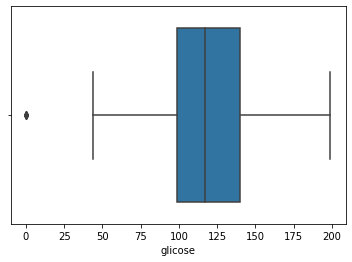

In [ ]:
sns.boxplot(x="glicose", data=df_diabetes)

Há poucos outliers, portanto posso fazer a imputação pela média

In [ ]:
#Filtro os valores 0 ou NaN e substituo pela média
df_diabetes["glicose"].loc[ (df_diabetes.glicose == 0) |
                                 (df_diabetes.glicose.isna())]  = np.nanmean(df_diabetes['glicose'])

Analiso o campo **pressao_dias**

In [ ]:
len(df_diabetes["pressao_dias"].loc[ (df_diabetes.pressao_dias == 0) | (df_diabetes.pressao_dias.isna())] )

35

Achamos 35 valores zerados ou ausentes. <br/>
Como isso representa menos de 5% do nosso dataset, opto por manter a variável e imputar os valores ausentes. <br/> Rodo o gráfico de boxplot para saber se há outliers. Caso haja, podemos imputar pela mediana para minimizar o efeito dos outliers

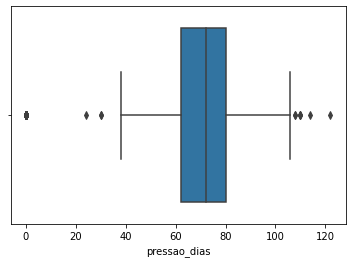

In [ ]:
sns.boxplot(x="pressao_dias", data=df_diabetes)

Como há alguns outliers, opto por fazer a imputação pela mediana

In [ ]:
#Filtro os valores 0 ou NaN e substituo pela mediana
df_diabetes["pressao_dias"].loc[ (df_diabetes.pressao_dias == 0) |
                                 (df_diabetes.pressao_dias.isna())]  = np.nanmedian(df_diabetes['pressao_dias'])

**espessura_pele**

In [ ]:
len(df_diabetes["espessura_pele"].loc[ (df_diabetes.espessura_pele == 0) | (df_diabetes.espessura_pele.isna())] )

227

Achamos 227 valores zerados ou ausentes. <br/>
Como isso representa quase 30% do dataset, prefiro excluir do modelo a variável. <br />

In [ ]:
df_diabetes.drop(['espessura_pele'],axis=1, inplace=True)
df_diabetes.head()

,num_gravidez,glicose,pressao_dias,teste_insulina,imc,diabetes_pedigree_function,idade,diabetes
0,6,148.0,72,0,33.6,0.627,50,1
1,1,85.0,66,0,26.6,0.351,31,0
2,8,183.0,64,0,23.3,0.672,32,1
3,1,89.0,66,94,28.1,0.167,21,0
4,0,137.0,40,168,43.1,2.288,33,1


**teste_insulina**

In [ ]:
len(df_diabetes["teste_insulina"].loc[ (df_diabetes.teste_insulina == 0) | (df_diabetes.teste_insulina.isna())] )

374

Achamos 374 valores zerados ou ausentes. <br/>
Como isso representa mais de 30% do dataset, prefiro excluir do modelo a variável. <br />

In [ ]:
df_diabetes.drop(['teste_insulina'],axis=1, inplace=True)
df_diabetes.head()

,num_gravidez,glicose,pressao_dias,imc,diabetes_pedigree_function,idade,diabetes
0,6,148.0,72,33.6,0.627,50,1
1,1,85.0,66,26.6,0.351,31,0
2,8,183.0,64,23.3,0.672,32,1
3,1,89.0,66,28.1,0.167,21,0
4,0,137.0,40,43.1,2.288,33,1


**imc**

In [ ]:
len(df_diabetes["imc"].loc[ (df_diabetes.imc == 0) | (df_diabetes.imc.isna())] )

11

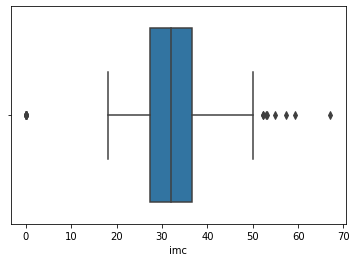

In [ ]:
sns.boxplot(x="imc", data=df_diabetes)

Como há bastante outliers, opto pela imputação pela mediana

In [ ]:
#Filtro os valores 0 ou NaN e substituo pela mediana
df_diabetes["imc"].loc[ (df_diabetes.imc == 0) |
                                 (df_diabetes.imc.isna())]  = np.nanmedian(df_diabetes['imc'])

**diabetes_pedigree_function (dbf)**

In [ ]:
len(df_diabetes["diabetes_pedigree_function"].loc[ (df_diabetes.diabetes_pedigree_function == 0) | (df_diabetes.diabetes_pedigree_function.isna())] )

0

Como não há valores zerados ou ausentes, mantemos o dbf

**idade**

In [ ]:
len(df_diabetes["idade"].loc[ (df_diabetes.idade == 0) | (df_diabetes.idade.isna())] )

0

Como não há valores zerados ou ausentes, mantemos a idade

##1.6) Verifico a correlação entre as variáveis
Como vimos na análise exploratória, é necessário tratar as variáveis missing.

In [ ]:
df_corr = df_diabetes.drop(['diabetes'],axis=1).corr(method="pearson").abs()
df_corr

,num_gravidez,glicose,pressao_dias,imc,diabetes_pedigree_function,idade
num_gravidez,1.000000,0.127964,0.208615,0.021546,0.033523,0.544341
glicose,0.127964,1.000000,0.218623,0.231469,0.137106,0.266600
pressao_dias,0.208615,0.218623,1.000000,0.281132,0.002378,0.324915
imc,0.021546,0.231469,0.281132,1.000000,0.153506,0.025744
diabetes_pedigree_function,0.033523,0.137106,0.002378,0.153506,1.000000,0.033561
idade,0.544341,0.266600,0.324915,0.025744,0.033561,1.000000


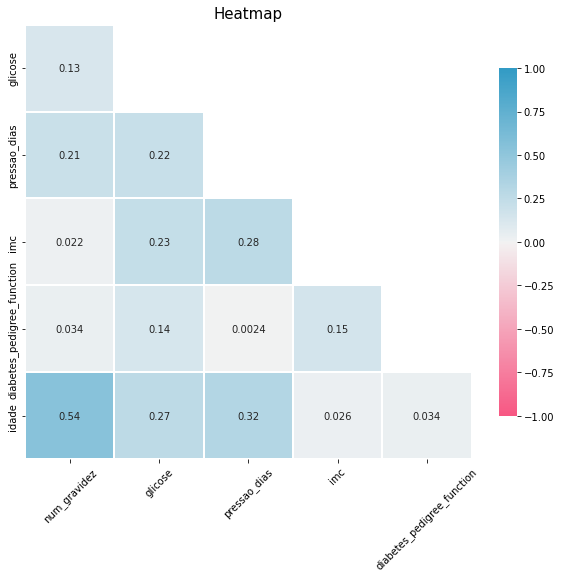

In [ ]:
#Defino o tamanho da figura (em polegadas)
f, ax = plt.subplots(figsize=(10,8))

#Crio uma matriz de valores "False" para o dataframe de correlações
mascara_corr = np.zeros_like(df_corr, dtype=bool)

#Coloco o valor true na parte superior diagonal da matriz
mascara_corr[np.triu_indices_from(mascara_corr)] = True

#Removo a primeira linha e a última coluna da mascara fazendo o slicing
mascara_corr = mascara_corr[1:,:-1]

#utilizo outro mapa de cores para suavizar o gráfico
mapa_cor = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

#Gero o mapa de calor
sns.heatmap(df_corr.iloc[1:,:-1],              #dataframe de correlações
            mask=mascara_corr,               #mascara para ocultar a parte diagonal superior
            cmap=mapa_cor,              #Mapa de Cor (https://matplotlib.org/stable/tutorials/colors/colormaps.html)
            linewidths = 1,             #Espessura das linhas
            cbar_kws = {"shrink": .8},  #diminuo o tamanho das legendas
            annot=True,                 #escreve o valor das correlações dentro das caixas do gráfico
            vmin=-1,                    #Valor mínimo para exibição
            vmax=1                      #Valor máximo para exibição
            )

#Crio um título para o gráfico
plt.title("Heatmap", size=15)

#Inclino o texto do eixo x
plt.xticks(rotation=45)

#Finalmente, exibo o gráfico
plt.show()

Como não há correlações muito fortes (acima de 0,9) mantemos todas as variáveis

#2) Desenvolvimento do Modelo preditivo

## 2.1) Defino o desfecho (Y) - Coluna Diabetes

O desfecho também é chamado de variável dependente

In [ ]:
Y = df_diabetes.iloc[:,6]
Y.value_counts()

0    500
1    268
Name: diabetes, dtype: int64

Veja que há um desbalanceamento no desfecho. Há 268 casos de diabéticos e 500 de não diabéticos

## 2.1) Defino as variáveis preditoras (X)
Obs: Também chamadas de variáveis independentes <br />
**X (Preditores)**:<br/>num_gravidez, glicose, pressao_dias, imc, diabetes_pedigree_function,idade


In [ ]:
df_diabetes.head()

,num_gravidez,glicose,pressao_dias,imc,diabetes_pedigree_function,idade,diabetes
0,6,148.0,72,33.6,0.627,50,1
1,1,85.0,66,26.6,0.351,31,0
2,8,183.0,64,23.3,0.672,32,1
3,1,89.0,66,28.1,0.167,21,0
4,0,137.0,40,43.1,2.288,33,1


In [ ]:
X = df_diabetes.iloc[:,0:6]
X.head()

,num_gravidez,glicose,pressao_dias,imc,diabetes_pedigree_function,idade
0,6,148.0,72,33.6,0.627,50
1,1,85.0,66,26.6,0.351,31
2,8,183.0,64,23.3,0.672,32
3,1,89.0,66,28.1,0.167,21
4,0,137.0,40,43.1,2.288,33


## 2.2) Divido os dados para treino e testes

Separo 70% dos dados para treinamento e 30% para testes

In [ ]:
#Defino uma semente (seed) para reprodutibilidade do experimento
seed = 42
#Defino o percentual do conjunto de testes
test_size = 0.30

#Uso a função train_test_split() do scikit-learn para dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)

Vejo o resultado da divisão

In [ ]:
print(X_train.shape)
print(y_train.shape)

(537, 6)
(537,)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(231, 6)
(231,)


##2.3) Ajusto o modelo com os dados de treino

In [ ]:
#Crio um objeto para treinar o modelo logistico com os dados de treino (modelo_lr)
modelo_lr = LogisticRegression()
modelo_lr.fit(X_train,y_train)

LogisticRegression()

Testo o modelo nos dados de testes, simulando novos dados

In [ ]:
#Obs: O modelo retorna o desfecho binário com o método predict (0 ou 1 - y_pred)
#Obs: O modelo retorna as probabilidades calculadas com o predict_proba
y_pred = modelo_lr.predict(X_test)
y_pred_proba = modelo_lr.predict_proba(X_test)[:,1]

Avalio o modelo com base na performance nos dados de **teste**

In [ ]:
#Sempre avalie a eficácia do modelo nos dados de teste e não de treino, pois pode haver sobreajuste no treino
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(f"AUC: { roc_auc_score(y_test, y_pred_proba) } ")

Accuracy: 74.03%
AUC: 0.7957781456953642 


O modelo apresentou boa acurácia (acima de 74%) e mostrou-se assertivo para os casos e não casos ao analisar a área abaixo da curva AUC. <br/>
Obs: estes conceitos farão parte de um próximo curso em que detalharemos métricas e formas de otimizar um modelo

##2.4) Tópico Avançado: Normalização e Padronização
Em alguns casos a diferença de escala das variáveis preditoras pode deixar o modelo enviesado. Portanto, a padronização pelo zscore ou a normalização dos dados, pode melhorar a performance do modelo.<br />
Obs: conceitos fazem parte de outro curso mais avançado

$ z = \frac{(x - u)}{s} $

Aplicamos a padronização pelo zscore (cenas de um próximo capítulo!) <br/>

In [ ]:
scaler_train = StandardScaler().fit(X_train)

In [ ]:
scaler_test = StandardScaler().fit(X_test)

In [ ]:
X_train_scaled = scaler_train.transform(X_train)

In [ ]:
X_train_scaled

array([[-0.8362943 , -0.89585789, -1.00322115, -1.20341544, -0.61421636,
        -0.94861028],
       [ 0.39072767, -0.56374882, -0.01909007,  0.66489466, -0.90973787,
        -0.43466673],
       [-1.14304979,  0.43257839, -0.34713376,  1.44096193, -0.30699103,
        -0.77729576],
       ...,
       [ 1.92450513, -0.69659245,  1.12906286,  1.91522526,  1.94892066,
         0.42190587],
       [-1.14304979,  0.63184384, -0.01909007,  1.45533355, -0.77514391,
        -0.34900947],
       [-1.14304979,  0.10046932,  1.9491721 , -1.40461807, -0.60836445,
        -1.03426754]])

In [ ]:
X_test_scaled = scaler_test.transform(X_test)

In [ ]:
modelo_lr_scaled = LogisticRegression()
modelo_lr_scaled.fit(X_train_scaled,y_train)

LogisticRegression()

In [ ]:
y_pred_scaled = modelo_lr_scaled.predict(X_test_scaled)
y_pred_proba_scaled = modelo_lr_scaled.predict_proba(X_test_scaled)[:,1]

In [ ]:
y_pred_scaled

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [ ]:
y_pred_proba_scaled

array([0.25166059, 0.17506581, 0.10339873, 0.11607962, 0.44785052,
       0.43709977, 0.01048842, 0.34588335, 0.55796631, 0.75168116,
       0.19358926, 0.89495918, 0.43488568, 0.23313704, 0.05357667,
       0.34043092, 0.11181451, 0.06050095, 0.71179213, 0.61047085,
       0.1698359 , 0.06871516, 0.43639447, 0.08778619, 0.54135939,
       0.88354425, 0.0897278 , 0.02513218, 0.30066382, 0.09539498,
       0.92639701, 0.85013915, 0.84893409, 0.63829763, 0.5767358 ,
       0.68744072, 0.95335468, 0.19189504, 0.40771971, 0.53230844,
       0.05134102, 0.48033782, 0.48483643, 0.25657037, 0.02251297,
       0.5561509 , 0.57182728, 0.18386247, 0.24528738, 0.96685487,
       0.03641403, 0.64570996, 0.84719851, 0.22210505, 0.11199307,
       0.03184529, 0.74503093, 0.04568512, 0.38883411, 0.7525022 ,
       0.69515687, 0.32132217, 0.22499662, 0.17818482, 0.08461657,
       0.6329075 , 0.03535866, 0.78616393, 0.02713037, 0.86708715,
       0.72834483, 0.05429624, 0.12098012, 0.11399577, 0.06980

In [ ]:
# evaluate predictions
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_scaled)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(f"AUC: { roc_auc_score(y_test, y_pred_proba_scaled) } ")

Accuracy: 74.89%
AUC: 0.7979304635761589 


Veja que neste caso, a padronização melhorou um pouco a performance do modelo

**Obrigado**